# Subreddit Classifier - r/CryptoCurrency and r/Investing

## Content
- [Background](#Background)
- [Web Scraping](#Web-Scraping)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualizations](#Data-Visualizations)
- [Classification Modeling](#Classification-Modeling)
- [Conclusion](#Conclusions)

## Problem Statement

As a new investment company which has 2 main trading desks - one for traditional securities and another for cryptocurrency, we find Reddit to be a potential source of information on trading news. The speculative discussions spanning a wide range of topics are something we would like to monitor on a daily basis. [*r/investing*](https://www.reddit.com/r/investing/) and [*r/CryptoCurrency*](https://www.reddit.com/r/cryptocurrency/), in particular, are especially of interest to our company. 

However, because we are a small company with limited manpower to spare, we are looking into help in the form of a classifier model to accurately sort the posts accurately so that our employees in the relevant department can quicky access the right information for their needs.

## Background

Reddit is a social news aggregation, web content rating, and discussion website that has been featured in a number of headlines recently due to the unexpected role it played in the prices of stocks. From the now-confirmed scam of Squid Game coin to the Gamestop saga on r/wallstreetbets, traders who tended to scrutinize traditional news for information have started turning to Reddit as well as a source of information ([*Source*](https://markets.businessinsider.com/news/stocks/reddit-stocks-10-most-discussed-tesla-gamestop-wallstreetbets-november-2-2021-11)). Due to the nature of Reddit as an online discussion platform, crytocurrency is also a popular topic there with r/cryptocurrency having a total of 3.8 million members in the lively community ([*Source*](https://www.reddit.com/r/cryptocurrency/)).

Using the ShiftPush API, our team collected about 2000 posts from the subreddits of cryptocurrency and investing, and will be building a suitable Natural Language Processing classifier model to cater to the needs of the company. We have also narrowed down the training model types to: Logisitic Regression and Naive Bayes. This report will walk the reader through the process of setting up the classifier model for the company.

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|title|*str*|crypto_df|The words found in the post title in r/CryptoCurrency|
|title|*str*|invest_df|The words found in the post title in r/investing|
|selftext|*str*|crypto_df|The words found in the post body in r/CryptoCurrency|
|selftext|*str*|invest_df|The words found in the post body in r/investing|
|all_text|*str*|combined_df|The words found both the title and post body in the combined r/CryptoCurrency and /investing dataframe|
|tok_lemma_all_text|*str*|clean_df| The tokenized and lemmatized words from combined_df|

## Import

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')
import re

# Enables Pandas to display all the columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Enables Pandas to display long strings properly
pd.options.display.max_colwidth = 100

# Web Scraping

## Scraping r/CryptoCurrency

In [2]:
crypto_df = pd.DataFrame()
insufficient_data = True
time = 1635177599     # SG Time: Monday, 25 October 2021 23:59:59
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'cryptocurrency',
        'size': 100,
        'before': time,}

    # This is used later on to check if the program is continously looping onto itself.
    old_time = time
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit','author', 'title', 'selftext', 'created_utc', 'full_link']]
    
    # Dropping unusable selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Adding data to main dataframe
    crypto_df = pd.concat(objs=[crypto_df, selected_cols_clean], axis=0)
    
    # Drop duplicate posts within r/Cryptocurrency
    crypto_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(crypto_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(crypto_df))
    
    # Setting new time for next loop as the earliest time created out of the 100 posts obtained
    time = crypto_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_time == time:
        print('INFINITE LOOP due to same oldest post')
        insufficient_data = False
    
    if len(crypto_df) >= 2000:
        insufficient_data = False
        
crypto_df.to_csv('datasets/crypto.csv')

1 25
2 58
3 92
4 115
5 146
6 171
7 192
8 215
9 246
10 263
11 287
12 309
13 333
14 362
15 389
16 408
17 438
18 469
19 508
20 536
21 567
22 592
23 622
24 648
25 675
26 711
27 734
28 752
29 775
30 802
31 823
32 861
33 893
34 921
35 945
36 964
37 989
38 1012
39 1042
40 1059
41 1084
42 1115
43 1139
44 1167
45 1190
46 1222
47 1252
48 1283
49 1309
50 1334
51 1359
52 1384
53 1409
54 1440
55 1473
56 1500
57 1520
58 1542
59 1570
60 1588
61 1608
62 1633
63 1660
64 1684
65 1712
66 1738
67 1772
68 1795
69 1826
70 1843
71 1870
72 1883
73 1905
74 1938
75 1975
76 2002


## Scraping r/investing

In [3]:
invest_df = pd.DataFrame()
insufficient_data = True
time = 1635177599     # SG Time: Monday, 25 October 2021 23:59:59
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'investing',
        'size': 100,
        'before': time,}

    # This is used later on to check if the program is continously looping onto itself.
    old_time = time
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit','author', 'title', 'selftext', 'created_utc', 'full_link']]
    
    # Dropping removed, deleted and null selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Add to main dataframe
    invest_df = pd.concat(objs=[invest_df, selected_cols_clean], axis=0)
    
    # Drop duplicate posts within r/investing
    invest_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(invest_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(invest_df))
    
    # Setting new time for next loop as the earliest time created out of the 100 posts obtained
    time = invest_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_time == time:
        print('INFINITE LOOP due to same last old post')
        insufficient_data = False
    
    if len(invest_df) >= 2000:
        insufficient_data = False
        
invest_df.to_csv('datasets/invest.csv')

1 17
2 26
3 38
4 48
5 56
6 71
7 84
8 95
9 111
10 122
11 137
12 146
13 158
14 171
15 183
16 198
17 212
18 225
19 241
20 251
21 268
22 285
23 296
24 321
25 334
26 343
27 355
28 365
29 380
30 394
31 405
32 417
33 437
34 451
35 466
36 476
37 493
38 508
39 531
40 543
41 564
42 575
43 586
44 600
45 610
46 626
47 651
48 661
49 676
50 682
51 700
52 711
53 730
54 746
55 762
56 789
57 796
58 810
59 823
60 839
61 854
62 870
63 888
64 907
65 920
66 936
67 953
68 970
69 986
70 1004
71 1028
72 1051
73 1067
74 1085
75 1100
76 1116
77 1131
78 1145
79 1165
80 1179
81 1199
82 1210
83 1231
84 1251
85 1273
86 1291
87 1308
88 1324
89 1334
90 1350
91 1365
92 1388
93 1408
94 1424
95 1442
96 1459
97 1482
98 1502
99 1526
100 1548
101 1561
102 1578
103 1593
104 1597
105 1613
106 1633
107 1655
108 1671
109 1684
110 1703
111 1720
112 1733
113 1743
114 1757
115 1776
116 1794
117 1811
118 1853
119 1890
120 1920
121 1951
122 1972
123 2006


The data collected were 2000 posts from r/cryptocurrency and r/investing, backdating from Monday, 25 October 2021, 23:59:59 SGT.

The 'null' posts, 'deleted' posts (by the users) and 'removed' posts (by the subreddit moderators) were dropped during the loop to achieve a more efficient yield during the web scraping process. Duplicates of posts within the individual subreddits were also dropped.

# Part 2

# Data Cleaning

In [4]:
crypto_df = pd.read_csv('datasets/crypto.csv')
invest_df = pd.read_csv('datasets/invest.csv')

In [5]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2002 non-null   int64 
 1   subreddit    2002 non-null   object
 2   author       2002 non-null   object
 3   title        2002 non-null   object
 4   selftext     2002 non-null   object
 5   created_utc  2002 non-null   int64 
 6   full_link    2002 non-null   object
dtypes: int64(2), object(5)
memory usage: 109.6+ KB


In [6]:
invest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2006 non-null   int64 
 1   subreddit    2006 non-null   object
 2   author       2006 non-null   object
 3   title        2006 non-null   object
 4   selftext     2006 non-null   object
 5   created_utc  2006 non-null   int64 
 6   full_link    2006 non-null   object
dtypes: int64(2), object(5)
memory usage: 109.8+ KB


Our final dataset consists of 2002 unique entries from r/CryptoCurrency and 2006 unique entries from r/investing. Information collected are the post title, body, authors, time created, authors and subreddit membership.

In [7]:
# drop unwanted columns
invest_df = invest_df.drop(columns=['Unnamed: 0','full_link', 'created_utc'])
crypto_df = crypto_df.drop(columns=['Unnamed: 0','full_link', 'created_utc'])

In [8]:
# check for null value in crypto_df
crypto_df[crypto_df['selftext'].isnull()]

,subreddit,author,title,selftext


In [9]:
# check for null value in invest_df
invest_df[invest_df['selftext'].isnull()]

,subreddit,author,title,selftext


In [10]:
# check for common post between both df
crypto_df[crypto_df["selftext"].isin(invest_df["selftext"]) == True]

,subreddit,author,title,selftext


No instances of null posts (posts without words) and cross-posting between the 2 subreddits were found.

### Combine into a single dataframe

In [11]:
# Concatenate df_investing and df_crypto
combined_df = pd.concat(objs=[invest_df, crypto_df], axis=0)
combined_df.reset_index(inplace=True, drop=True)
combined_df['subreddit'].value_counts()

investing         2006
CryptoCurrency    2002
Name: subreddit, dtype: int64

In [12]:
# drop individual index columns and create new index
combined_df.reset_index(inplace=True, drop=True)
combined_df['subreddit'].value_counts()

investing         2006
CryptoCurrency    2002
Name: subreddit, dtype: int64

In [13]:
# Checking dataframe
combined_df.head(1)

,subreddit,author,title,selftext
0,investing,mildcharts,A Great Short Setup on NYSE,[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n\n* Double top on ATH level...


In [14]:
# Dummify subreddits into numerical value
combined_df['subreddit_cryptocurrency'] = combined_df['subreddit'].map(lambda x: 1 if x == 'CryptoCurrency' else 0)
combined_df.head(1)

,subreddit,author,title,selftext,subreddit_cryptocurrency
0,investing,mildcharts,A Great Short Setup on NYSE,[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n\n* Double top on ATH level...,0


# Exploratory Data Analysis

### Word Count

In [15]:
# concat title and selftext columns
combined_df["all_text"] = combined_df["title"] + combined_df["selftext"]

# add columns for text lengths
combined_df['text_len'] = combined_df['all_text'].apply(len)
combined_df.head(1)

,subreddit,author,title,selftext,subreddit_cryptocurrency,all_text,text_len
0,investing,mildcharts,A Great Short Setup on NYSE,[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n\n* Double top on ATH level...,0,A Great Short Setup on NYSE[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n...,144


<Figure size 1440x5760 with 0 Axes>

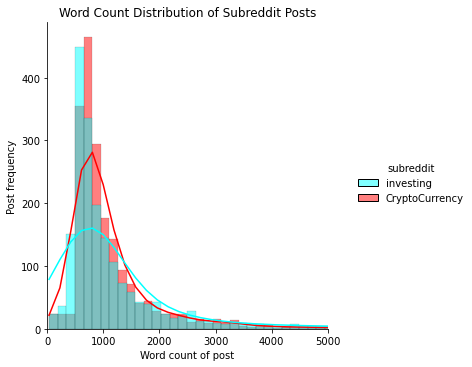

In [16]:
# word count function
def word_counter(row):
    row['word_count'] = len(row['all_text'])
    return row

combined_df = combined_df.apply(word_counter, axis=1)

# visualization

plt.figure(figsize=(20,80))
sns.displot(
    x = combined_df['word_count'],
    hue = combined_df['subreddit'],
    palette = ['cyan', 'red'],
    bins = 250,
    kde = True
);
plt.xlim(0, 5000)
plt.title('Word Count Distribution of Subreddit Posts')
plt.ylabel('Post frequency')
plt.xlabel('Word count of post');

Most subreddit posts contain between 500 - 1000 words, with both r/cryptcurrency and r/investing a trailing tail becuase Reddit has a very high maximum lenge of 40,000 characters that most users are unlikely to meet.

### Unique Posts and Authors

In [17]:
# not too sure why this cell sometimes fail to run, pls restart kernel if it happens!
unique_posts = len(set(combined_df['all_text']))
unique_authors = len(set(combined_df['author']))
print(f'{unique_posts} posts collected from both subreddits were created by {unique_authors} unique authors.')

4008 posts collected from both subreddits were created by 3017 unique authors.


In [18]:
combined_df.head(1)

,subreddit,author,title,selftext,subreddit_cryptocurrency,all_text,text_len,word_count
0,investing,mildcharts,A Great Short Setup on NYSE,[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n\n* Double top on ATH level...,0,A Great Short Setup on NYSE[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n...,144,144


In [19]:
# drop unwanted columns
combined_df = combined_df.drop(columns= ['author', 'text_len', 'word_count'])
# check
combined_df.head(1)

,subreddit,title,selftext,subreddit_cryptocurrency,all_text
0,investing,A Great Short Setup on NYSE,[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n\n* Double top on ATH level...,0,A Great Short Setup on NYSE[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n...


### Regex

In [20]:
def regex(text):
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub('http\S+', '', text)
    text = re.sub(r'\&\w*;', '', text)
    text = re.sub('xa0', '', str(text)).strip()
    text = re.sub('x200b', '', str(text)).strip()
        
    # Make texts lowercase
    text = text.lower()
    
    # Remove url
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w*', '', text)
    
    # Remove new lines
    text = text.replace('\n',' ').lower()
        
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
        
    # Remove texts with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove special characters
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    return text

In [21]:
combined_df['selftext'] = combined_df['selftext'].apply(regex)
combined_df['title'] = combined_df['title'].apply(regex)
combined_df.head(1)

,subreddit,title,selftext,subreddit_cryptocurrency,all_text
0,investing,great short setup nyse,snapshot double top ath level bullish rsi divergence,0,A Great Short Setup on NYSE[Snapshot](https://www.tradingview.com/x/xdfUPjmd/)\n\n&amp;#x200B;\n...


### Stopwords

In [22]:
all_stopwords = stopwords.words('english')

In [23]:
additional_stopwords = ['wa', 'ha', 'like', 'would',
                        'filler', 'one', '000 000 000']
all_stopwords.extend(additional_stopwords)

The additional stopwords are common words between the 2 subreddits that can be found below at the Count Vectorizer and ID-IDF Vectorizer top 20 words section.

### Tokenization and Lemmatization

In [24]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def tok_stem_drop(row):

    # Tokenize. This creates a list
    row['selftext'] = [tok for tok in tokenizer.tokenize(row['selftext'].lower())]
    row['title'] = [tok for tok in tokenizer.tokenize(row['title'].lower())]
    
    # Lemmatizing, Porter Stemming and Snowball Stemming
    row['lemma_selftext'] = [lemmatizer.lemmatize(tok) for tok in row['selftext']]
    row['lemma_title'] = [lemmatizer.lemmatize(tok) for tok in row['title']]
  
    # Drop stop words made in Part 1.3.2.
    row['lemma_stop_selftext'] = [tok for tok in row['lemma_selftext'] if tok not in all_stopwords]
    row['lemma_stop_title'] = [tok for tok in row['lemma_title'] if tok not in all_stopwords]
    
    # Extending 'title' list with corresponding 'selftext' list
    row['lemma_stop_title'].extend(row['lemma_stop_selftext'])
    row['title'].extend(row['selftext'])

    # Join title and selftext into string
    row['tok_lemma_all_text'] = ' '.join(row['lemma_stop_title'])   
    row['all_text'] = ' '.join(row['title'])
    
    return row
    
clean_df = combined_df.apply(tok_stem_drop, axis=1)

In [25]:
clean_df.head(1)

,subreddit,title,selftext,subreddit_cryptocurrency,all_text,lemma_selftext,lemma_title,lemma_stop_selftext,lemma_stop_title,tok_lemma_all_text
0,investing,"[great, short, setup, nyse, snapshot, double, top, ath, level, bullish, rsi, divergence]","[snapshot, double, top, ath, level, bullish, rsi, divergence]",0,great short setup nyse snapshot double top ath level bullish rsi divergence,"[snapshot, double, top, ath, level, bullish, rsi, divergence]","[great, short, setup, nyse]","[snapshot, double, top, ath, level, bullish, rsi, divergence]","[great, short, setup, nyse, snapshot, double, top, ath, level, bullish, rsi, divergence]",great short setup nyse snapshot double top ath level bullish rsi divergence


In [26]:
# remove unwanted columns
clean_df.drop(columns=['title', 'lemma_title','lemma_stop_selftext', 'lemma_stop_title'], inplace=True)

In [27]:
# check
clean_df.head(1)

,subreddit,selftext,subreddit_cryptocurrency,all_text,lemma_selftext,tok_lemma_all_text
0,investing,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",0,great short setup nyse snapshot double top ath level bullish rsi divergence,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",great short setup nyse snapshot double top ath level bullish rsi divergence


In [28]:
# check
crypto_df.shape

(2002, 4)

## Word Vectorization

### N-gram Frequency

The N-gram frequency is used to show the counts of each unique word in the subreddit. The more distinctive words that can be found in one subreddit but not the other, the more accurate our classifier model will be.

In [29]:
# create separate series for each subreddit
crypto_text = clean_df.loc[clean_df['subreddit'] == 'CryptoCurrency', 'tok_lemma_all_text']
invest_text = clean_df.loc[clean_df['subreddit'] == 'investing', 'tok_lemma_all_text']

In [30]:
crypto_text.head(1)

2006    binance afraid crypto com assume title say last couple week especially since cdc crypto com star...
Name: tok_lemma_all_text, dtype: object

# Data Visualizations

In [31]:
# create function for Count Vectorizer Visualization
def cvec_ngram(range_value):

    # Instantiate Vectorizer
    cvec_vectorizer = CountVectorizer(ngram_range=(range_value, range_value), min_df=5, max_features=100)
    
    # Creating dataframe based on vectorizer
    crypto_visual = cvec_vectorizer.fit_transform(crypto_text)
    crypto_visual_df = pd.DataFrame(crypto_visual.todense(), columns=cvec_vectorizer.get_feature_names())
    invest_visual = cvec_vectorizer.fit_transform(invest_text)
    invest_visual_df = pd.DataFrame(invest_visual.todense(), columns=cvec_vectorizer.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1) 
    crypto_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel2');
    plt.title('Top 10 Words in r/cryptocurrency (Count Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency (Count Vectorizer)', fontsize=15)
    plt.tick_params(labelsize=15)

    plt.subplot(1, 2, 2)
    invest_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel1');
    plt.title('Top 10 Words in r/investing (Count Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency (Count Vectorizer)', fontsize=15)
    plt.tick_params(labelsize=15)

    plt.tight_layout()

In [32]:
# create function for TF-IDF Vectorizer Visualization
def tvec_ngram(range_value):

    # Instantiate Vectorizer
    tvec_vectorizer = TfidfVectorizer(ngram_range=(range_value, range_value), min_df=5, max_features=100)
    
    # Creating dataframe based on vectorizer
    crypto_visual = tvec_vectorizer.fit_transform(crypto_text)
    crypto_visual_df = pd.DataFrame(crypto_visual.todense(), columns=tvec_vectorizer.get_feature_names())
    invest_visual = tvec_vectorizer.fit_transform(invest_text)
    invest_visual_df = pd.DataFrame(invest_visual.todense(), columns=tvec_vectorizer.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    crypto_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel2');
    plt.title('Top 10 Words in r/cryptocurrency (TFIDF Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency (TFIDF Vectorizer)', fontsize=15)
    plt.tick_params(labelsize=15)    

    plt.subplot(1, 2, 2)
    invest_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', colormap='Pastel1');
    plt.title('Top 10 Words in r/investing (TFIDF Vectorizer)', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.xlabel('Frequency (TFIDF Vectorizer)', fontsize=15)
    plt.tick_params(labelsize=15)
    
    plt.tight_layout()

### Unigram Graphs (Count Vectorizer, TF-IDF Vectorizer)

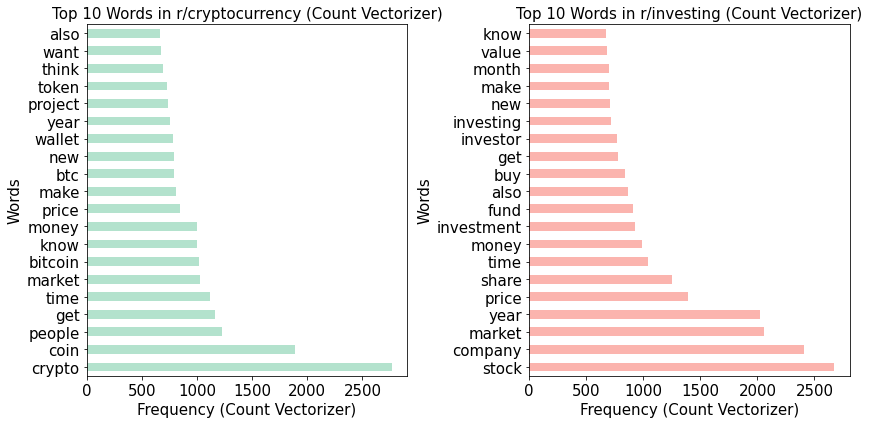

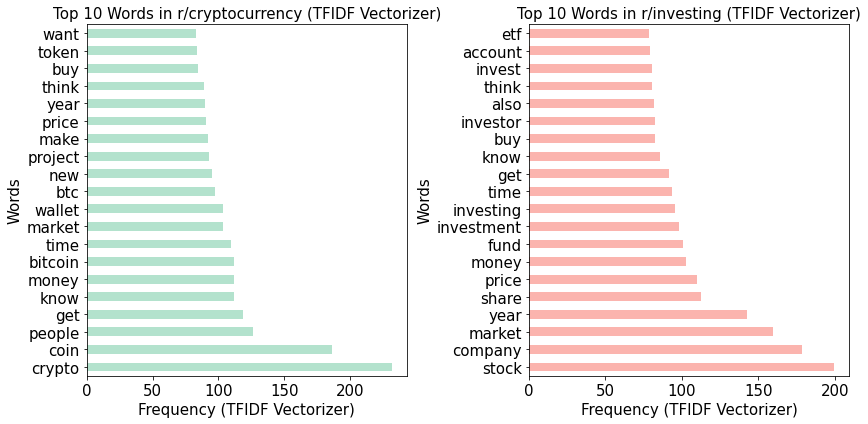

In [33]:
cvec_ngram(1)
tvec_ngram(1)

### Bigram Graphs (Count Vectorizer, TF-IDF Vectorizer)

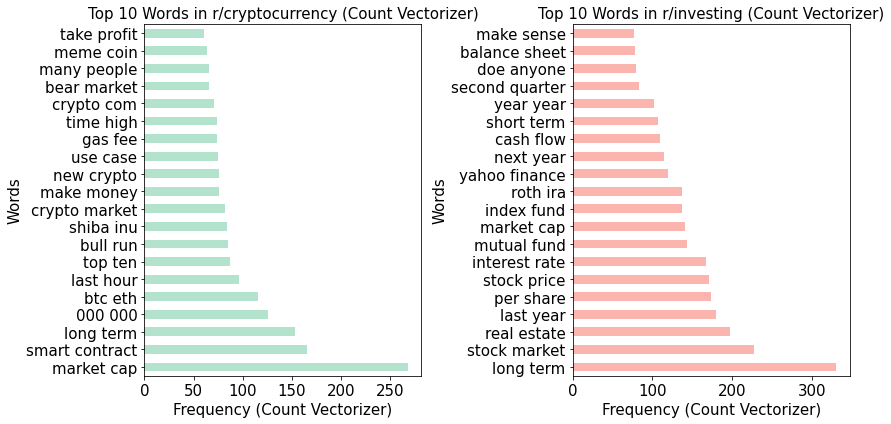

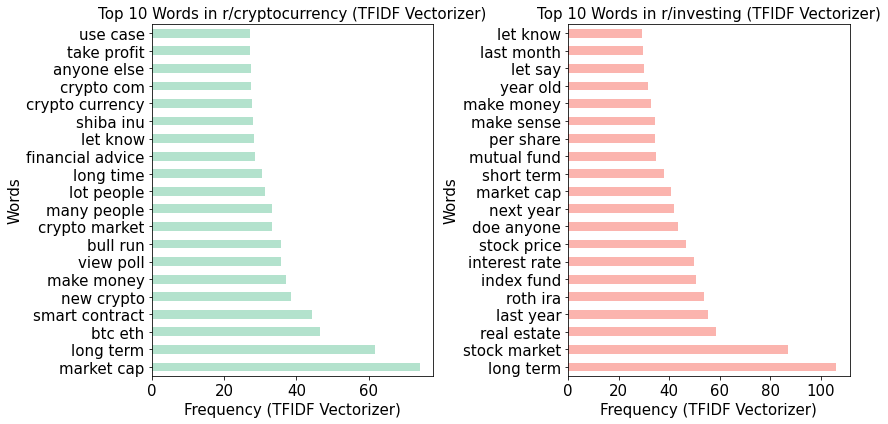

In [34]:
cvec_ngram(2)
tvec_ngram(2)

### Trigram Graphs (Count Vectorizer, TF-IDF Vectorizer)

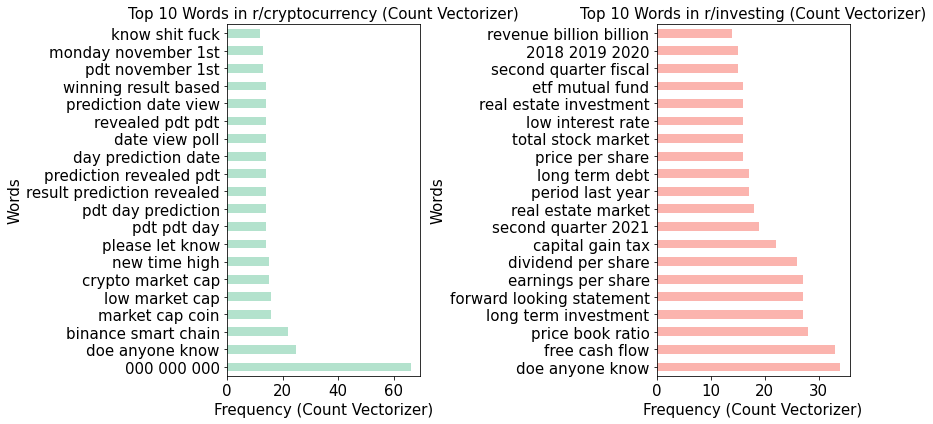

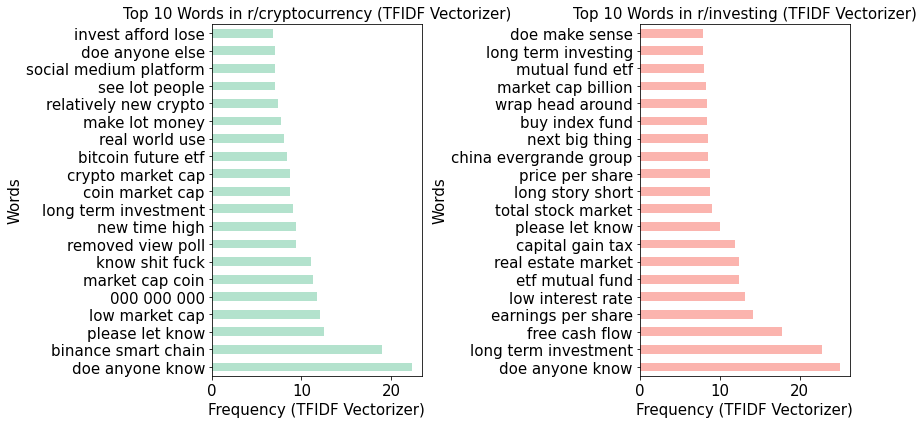

In [35]:
cvec_ngram(3)
tvec_ngram(3)

### EDA Observations

- There are common words between the 2 subreddits as seen in the unigram graphs that are not removed because they are weighted in the bigram and trigram graphs. Removing them would have an effect on the word groupings in the other n-grams (and vice-versa) that otherwise provides additional information.

- In terms of the word vectorizers, both the count vectorizer and TF-IDF vectorizer have distinctive words that do not appear in the other subreddit. For example, there are 'btc eth' for r/CryptoCurrency, which are the short forms of bitcoin and ethereum cryptocurrency respectively, and trigrams like 'china evergrande group' for r/investing.

- It is interesting that r/CryptoCurrency has more terms related to 'coin' and 'predict' while r/investing has more words related to funds and stocks such as 'buy inde fund' and 'stock market'.


## Word Cloud

### r/CryptoCurrency Word Cloud

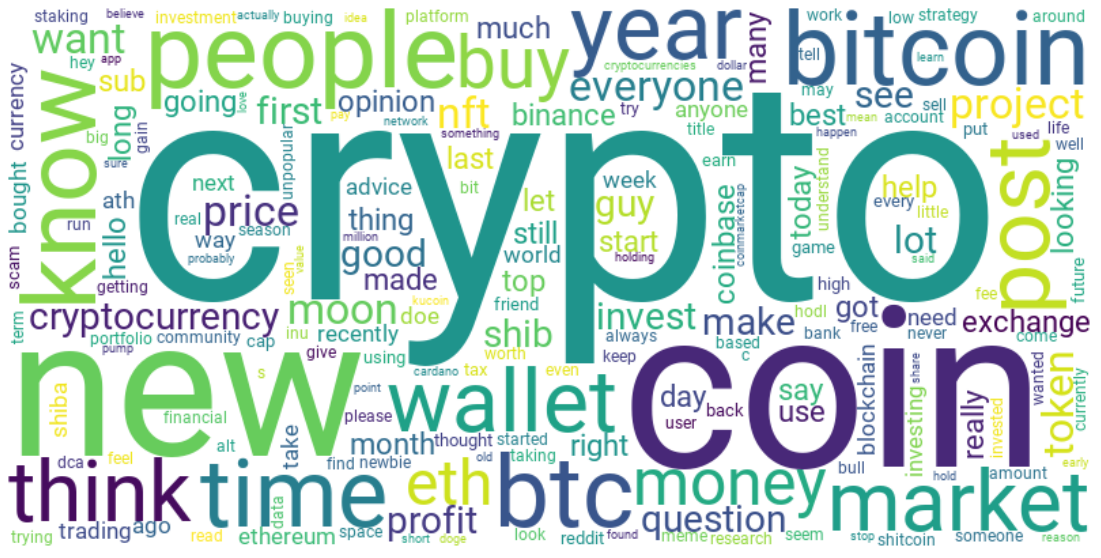

In [36]:
wordcloud_1 = WordCloud(font_path = 'font/Roboto-Regular.ttf', collocations = False, background_color = 'white', colormap='viridis', width=800, height=400).generate(str(crypto_text))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### r/investing Word Cloud

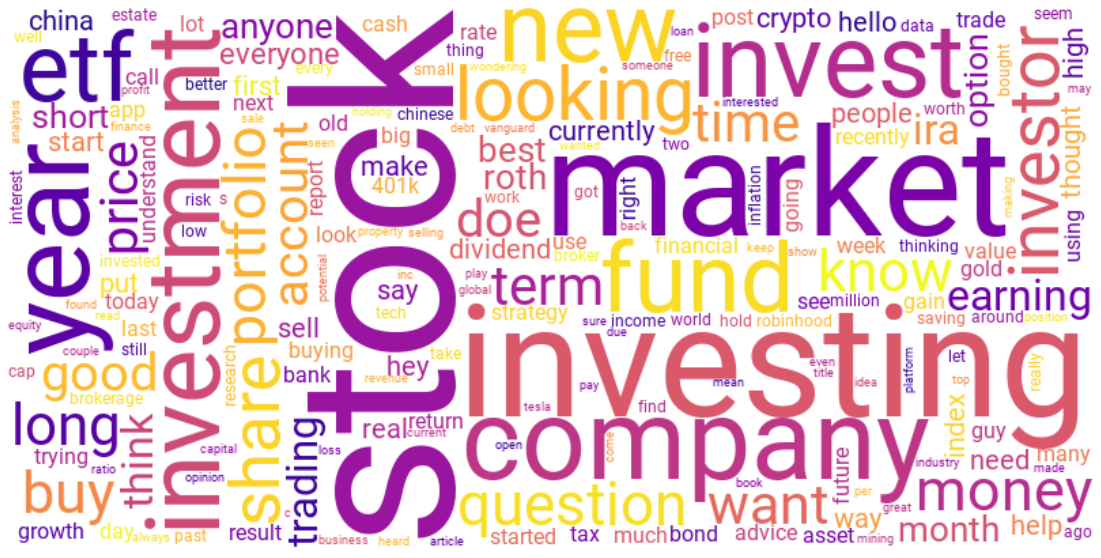

In [37]:
wordcloud_2 = WordCloud(font_path = 'font/Roboto-Regular.ttf', collocations = False, background_color = 'white', colormap='plasma', width=800, height=400).generate(str(invest_text))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

While word cloud visualizations have their limitations, both the above word clouds present a good overall picture of the text corpus in each subreddit and support our observations above.

In [38]:
clean_df.head(1)

,subreddit,selftext,subreddit_cryptocurrency,all_text,lemma_selftext,tok_lemma_all_text
0,investing,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",0,great short setup nyse snapshot double top ath level bullish rsi divergence,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",great short setup nyse snapshot double top ath level bullish rsi divergence


In [39]:
# export
clean_df.to_csv('datasets/clean_df.csv', index=False)

# Classification Modeling

### Baseline Model

In [40]:
clean_df.head(1)

,subreddit,selftext,subreddit_cryptocurrency,all_text,lemma_selftext,tok_lemma_all_text
0,investing,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",0,great short setup nyse snapshot double top ath level bullish rsi divergence,"[snapshot, double, top, ath, level, bullish, rsi, divergence]",great short setup nyse snapshot double top ath level bullish rsi divergence


In [41]:
clean_df['subreddit'].value_counts(normalize=True)

investing         0.500499
CryptoCurrency    0.499501
Name: subreddit, dtype: float64

Given a random subreddit post text, the probability of it belonging to r/CryptoCurrency is around 50.2%.

In [42]:
# test-train split
X = clean_df['tok_lemma_all_text']
y = clean_df['subreddit_cryptocurrency']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42,
                                                  stratify=y)

## Logistic Regression

The logistic model is used to model the probability of a certain class or event existing. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, such as the categorical membership in r/CryptoCurrency as in our case.

In [43]:
print(X_train.shape)
print(y_train.shape)

(3006,)
(3006,)


In [44]:
X_train.head(1)

158    beginner investor 1000 invest invest hello new wife budget saw surplus coming 1000 know much see...
Name: tok_lemma_all_text, dtype: object

In [45]:
def model(gs_vectorizer_model):
    gs_vectorizer_model.fit(X_train, y_train)
    model_preds = gs_vectorizer_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, model_preds).ravel()
    print(f'Best Score:                                {round(gs_vectorizer_model.best_score_, 3)*100}%')
    print(f'Train Score:                               {round(gs_vectorizer_model.score(X_train, y_train), 3)*100}%')
    print(f'Accuracy (Test Score):                     {round((tp+tn)/(tn+fp+fn+tp),3)*100}%')
    print(f'Misclassification:                         {round(1-(tp+tn)/(tn+fp+fn+tp),3)*100}%')
    print(f'Sensitivity / True Positive Rate / Recall: {round((tp)/(tp+fn),3)*100}%')
    print(f'Specificity / True Negative Rate:          {round(tn/(tn+fp),3)*100}%')
    print(f'Precision / Positive Predictive Value:     {round(tp/(tp+fp),3)*100}%')
    print(f'Best Parameters:                           {gs_vectorizer_model.best_params_}')
    plot_confusion_matrix(gs_vectorizer_model, 
                          X_test, y_test, 
                          cmap='Blues', 
                          values_format='d',
                          display_labels=['r/investing', 'r/CryptoCurrency']
                         );

Best Score:                                93.2%
Train Score:                               95.6%
Accuracy (Test Score):                     92.80000000000001%
Misclassification:                         7.199999999999999%
Sensitivity / True Positive Rate / Recall: 93.2%
Specificity / True Negative Rate:          92.4%
Precision / Positive Predictive Value:     92.5%
Best Parameters:                           {'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 'logit__cv': 10, 'logit__n_jobs': -1, 'logit__random_state': 42}


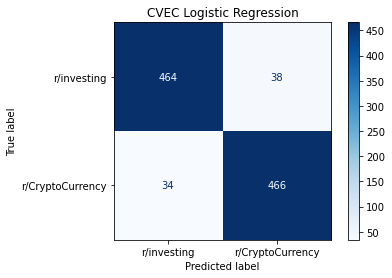

In [46]:
cvec = CountVectorizer()
logit = LogisticRegressionCV()

pipe_cvec_logit = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

pipe_cvec_logit_params = {
    'cvec__max_features': [4000],
    'cvec__ngram_range': [(1,2)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [10]}

gs_cvec_logit = GridSearchCV(
    estimator=pipe_cvec_logit,
    param_grid=pipe_cvec_logit_params,
    cv=5)

model(gs_cvec_logit)
plt.title('CVEC Logistic Regression');

Best Score:                                94.1%
Train Score:                               98.1%
Accuracy (Test Score):                     94.3%
Misclassification:                         5.7%
Sensitivity / True Positive Rate / Recall: 95.6%
Specificity / True Negative Rate:          93.0%
Precision / Positive Predictive Value:     93.2%
Best Parameters:                           {'logit__cv': 15, 'logit__n_jobs': -1, 'logit__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4)}


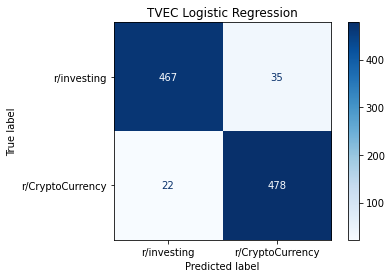

In [47]:
tvec = TfidfVectorizer()
logit = LogisticRegressionCV()

pipe_tvec_logit = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

pipe_tvec_logit_params = {
    'tvec__max_features': [3000],
    'tvec__ngram_range': [(1,4)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [15]
}

gs_tvec_logit = GridSearchCV(
    estimator=pipe_tvec_logit,
    param_grid=pipe_tvec_logit_params,
    cv=5)

model(gs_tvec_logit)
plt.title('TVEC Logistic Regression');

The TF-IDF Vectorizer has a more positive impact than the Count Vectorizer on the Logistic Regression model. The True Positive Rate and accuracy (test score) are higher at 95.6% and 94.3% respectively.

## Naive Bayes Model

Naive Bayes classifiers are probability classifiers that assume strong independence assumptions between features. While simple, it is a useful classification tool. Gaussian naive Bayes model will not be considered as the assumption of normal distribution has not been met. Bernoulli naïve Bayes are also not considered because the assumption of Boolean features are not met. The Binomial naive Bayes model will be used to test our corpus.

Best Score:                                92.10000000000001%
Train Score:                               94.39999999999999%
Accuracy (Test Score):                     93.10000000000001%
Misclassification:                         6.9%
Sensitivity / True Positive Rate / Recall: 97.39999999999999%
Specificity / True Negative Rate:          88.8%
Precision / Positive Predictive Value:     89.7%
Best Parameters:                           {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


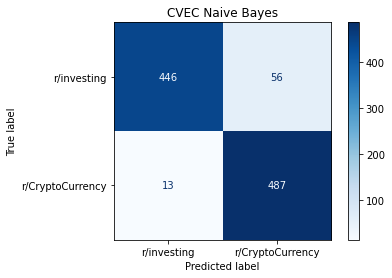

In [48]:
# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe_cvec_nb = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

pipe_cvec_nb_params = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(1, 2)]
}

# Instantiate GridSearchCV.
gs_cvec_nb = GridSearchCV(
    estimator=pipe_cvec_nb, 
    param_grid=pipe_cvec_nb_params, 
    cv=5)

model(gs_cvec_nb)
plt.title('CVEC Naive Bayes');

Best Score:                                93.2%
Train Score:                               96.0%
Accuracy (Test Score):                     93.7%
Misclassification:                         6.3%
Sensitivity / True Positive Rate / Recall: 96.2%
Specificity / True Negative Rate:          91.2%
Precision / Positive Predictive Value:     91.60000000000001%
Best Parameters:                           {'tvec__max_features': 7000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


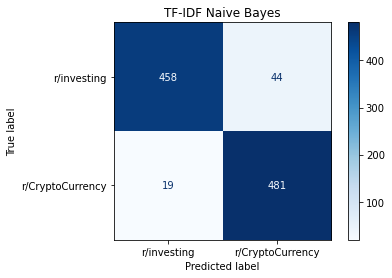

In [49]:
tvec = TfidfVectorizer()
nb = MultinomialNB()

# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_nb = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

pipe_tvec_nb_params = {
    'tvec__stop_words': ['english'],
    'tvec__max_features': [7000],
    'tvec__ngram_range': [(1, 3)],
}

# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(
    estimator=pipe_tvec_nb,
    param_grid=pipe_tvec_nb_params,
    cv=5)

model(gs_tvec_nb)
plt.title('TF-IDF Naive Bayes');

The naive Bayes models both performed better than the logistic Regression with TF-IVF Vectorizer in terms of the True Positive Rate, with the higher of the two models being the naive Bayes with Count Vectorizer. This model performed brilliantly with 97.3% True Positive Rate. Its test score is also adequate at 93.1%.

# Conclusion

We have chosen to go with the naive Bayes classifier model with Count Vectorizer for our company. True Positive Rate was prioritised beause of it is more crucial that our colleagues at both the traditional securities and crpytocurrency desks get a higher percentage of information relevant to their trading desks.